In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import xgboost as xgb

###### Data Preprocessing

In [52]:
dataset = pd.read_csv('./combined_dataset/combined_datasets.csv', error_bad_lines=False)
dataset = dataset[dataset['zipcode'] > 0]
# dataset = dataset[dataset['avg'] > 0]
dataset['zipcode'] = dataset['zipcode'].astype(int).astype(str)
dataset.head()

b'Skipping line 18654: expected 8 fields, saw 15\n'


,zipcode,subsystem,lat,long,sensor,parameter,datetime,avg
0,60601,chemsense,41.884607,-87.624577,no2,concentration,5/10/18 19:00,0.006243
1,60612,chemsense,41.871480,-87.676440,at0,temperature,5/1/18 12:00,27.369161
2,60610,chemsense,41.903632,-87.648093,so2,concentration,5/5/18 3:00,0.197254
3,60606,lightsense,41.883260,-87.633870,tmp421,temperature,5/4/18 2:00,39.129429
4,60625,metsense,41.968757,-87.679174,mma8452q,acceleration_x,5/1/18 3:00,-5.648554


In [53]:
dataset['datetime'] = pd.to_datetime(dataset['datetime'])
dataset= dataset[(dataset['datetime'] >= '2018-05-01') & (dataset['datetime'] <= '2018-06-30')]
dataset.head()

,zipcode,subsystem,lat,long,sensor,parameter,datetime,avg
0,60601,chemsense,41.884607,-87.624577,no2,concentration,2018-05-10 19:00:00,0.006243
1,60612,chemsense,41.871480,-87.676440,at0,temperature,2018-05-01 12:00:00,27.369161
2,60610,chemsense,41.903632,-87.648093,so2,concentration,2018-05-05 03:00:00,0.197254
3,60606,lightsense,41.883260,-87.633870,tmp421,temperature,2018-05-04 02:00:00,39.129429
4,60625,metsense,41.968757,-87.679174,mma8452q,acceleration_x,2018-05-01 03:00:00,-5.648554


In [54]:
# create training and test sets
display(dataset[dataset['parameter'] == 'pm2_5'].head(), dataset[dataset['parameter'] == 'pm2_5'].tail())

,zipcode,subsystem,lat,long,sensor,parameter,datetime,avg
10,60652,alphasense,41.751142,-87.712990,opc_n2,pm2_5,2018-05-08 18:00:00,3.100476
1952,60652,alphasense,41.751142,-87.712990,opc_n2,pm2_5,2018-05-06 19:00:00,1.517319
6705,60644,alphasense,41.880497,-87.745268,opc_n2,pm2_5,2018-05-14 09:00:00,0.000000
9748,60652,alphasense,41.751142,-87.712990,opc_n2,pm2_5,2018-06-12 07:00:00,2.271366
9749,60652,alphasense,41.751142,-87.712990,opc_n2,pm2_5,2018-06-13 20:00:00,0.043846


,zipcode,subsystem,lat,long,sensor,parameter,datetime,avg
6247279,60644,ELPC,41.878350,-87.755140,mobile,pm2_5,2018-06-16 14:00:00,46.576667
6247282,60644,ELPC,41.877303,-87.755051,mobile,pm2_5,2018-06-16 14:00:00,51.020000
6247316,60644,ELPC,41.875468,-87.754993,mobile,pm2_5,2018-06-16 15:00:00,51.506667
6247321,60644,ELPC,41.874876,-87.754998,mobile,pm2_5,2018-06-16 15:00:00,52.473333
6247328,60644,ELPC,41.874455,-87.754930,mobile,pm2_5,2018-06-16 15:00:00,51.623333


In [55]:
dataset['parameter'].unique()

array(['concentration', 'temperature', 'acceleration_x', 'acceleration_z',
       'point_5um_particle', 'pm2_5', 'humidity', 'intensity', 'pressure',
       '1um_particle', 'magnetic_field_x', 'magnetic_field_y',
       'magnetic_field_z', 'acceleration_y', '2_5um_particle', 'pm25_atm',
       'pm1', 'sample_flow_rate', 'pm1_cf1', 'pm10', 'pm10_cf1',
       'pm1_atm', 'sampling_period', 'pm10_atm', 'pm25_cf1',
       'point_3um_particle', 'fw', 'bins', '10um_particle',
       '5um_particle'], dtype=object)

In [56]:
dataset['sensor'].unique()

array(['no2', 'at0', 'so2', 'tmp421', 'mma8452q', 'tmp112', 'at3',
       'oxidizing_gases', 'pms7003', 'opc_n2', 'hih4030', 'mlx75305',
       'ml8511', 'at1', 'htu21d', 'at2', 'bmp180', 'co', 'tsl250rd',
       'lps25h', 'sht25', 'apds_9006_020', 'hih6130', 'tsl260rd',
       'pr103j2', 'tsys01', 'h2s', 'o3', 'reducing_gases', 'hmc5883l',
       'spv1840lr5h_b', 'mobile'], dtype=object)

In [57]:
columns = ['zipcode', 'lat', 'long', 'measure', 'datetime', 'avg']
data_sensors = dataset[dataset['sensor'].isin(['bmp180', 'co', 'h2s', 'htu21d', 'no2', 'o3', 'so2'])][['zipcode','lat', 'long','sensor', 'datetime', 'avg']]
data_pm = dataset[dataset['parameter'] == 'pm2_5'][['zipcode','lat', 'long','parameter', 'datetime', 'avg']]

data_sensors.columns = columns
data_pm.columns = columns

model_data = pd.concat([data_sensors, data_pm])

model_data.drop(['lat', 'long'], axis=1, inplace=True)

display(model_data.head(), model_data.tail())

,zipcode,measure,datetime,avg
0,60601,no2,2018-05-10 19:00:00,0.006243
2,60610,so2,2018-05-05 03:00:00,0.197254
17,60637,htu21d,2018-05-03 06:00:00,77.937832
19,60637,bmp180,2018-05-03 19:00:00,946.913125
20,60637,co,2018-05-04 08:00:00,1.548600


,zipcode,measure,datetime,avg
6247279,60644,pm2_5,2018-06-16 14:00:00,46.576667
6247282,60644,pm2_5,2018-06-16 14:00:00,51.020000
6247316,60644,pm2_5,2018-06-16 15:00:00,51.506667
6247321,60644,pm2_5,2018-06-16 15:00:00,52.473333
6247328,60644,pm2_5,2018-06-16 15:00:00,51.623333


In [65]:
metric_table = pd.pivot_table(model_data,
                              index=['zipcode', 'datetime'],
                              columns='measure',
                              values='avg', aggfunc=np.mean).reset_index().dropna()
metric_table.head()

measure,zipcode,datetime,bmp180,co,h2s,htu21d,no2,o3,pm2_5,so2
1473,60601,2018-05-02 16:00:00,537.265035,0.607887,-0.030094,30.109301,0.058793,0.017078,45.730777,0.128444
1495,60601,2018-05-03 14:00:00,534.040972,0.911039,-0.007952,41.874271,0.023329,0.051598,39.784889,-0.065280
1584,60601,2018-05-07 07:00:00,538.028497,0.173973,-0.005098,36.922448,0.040793,0.012613,39.616606,0.032210
1594,60601,2018-05-07 17:00:00,538.751888,-0.004556,-0.013195,27.423531,0.053397,0.007177,37.961650,0.041546
1608,60601,2018-05-08 07:00:00,533.180402,0.310357,-0.006664,26.390281,0.042669,0.013451,40.346947,0.051049


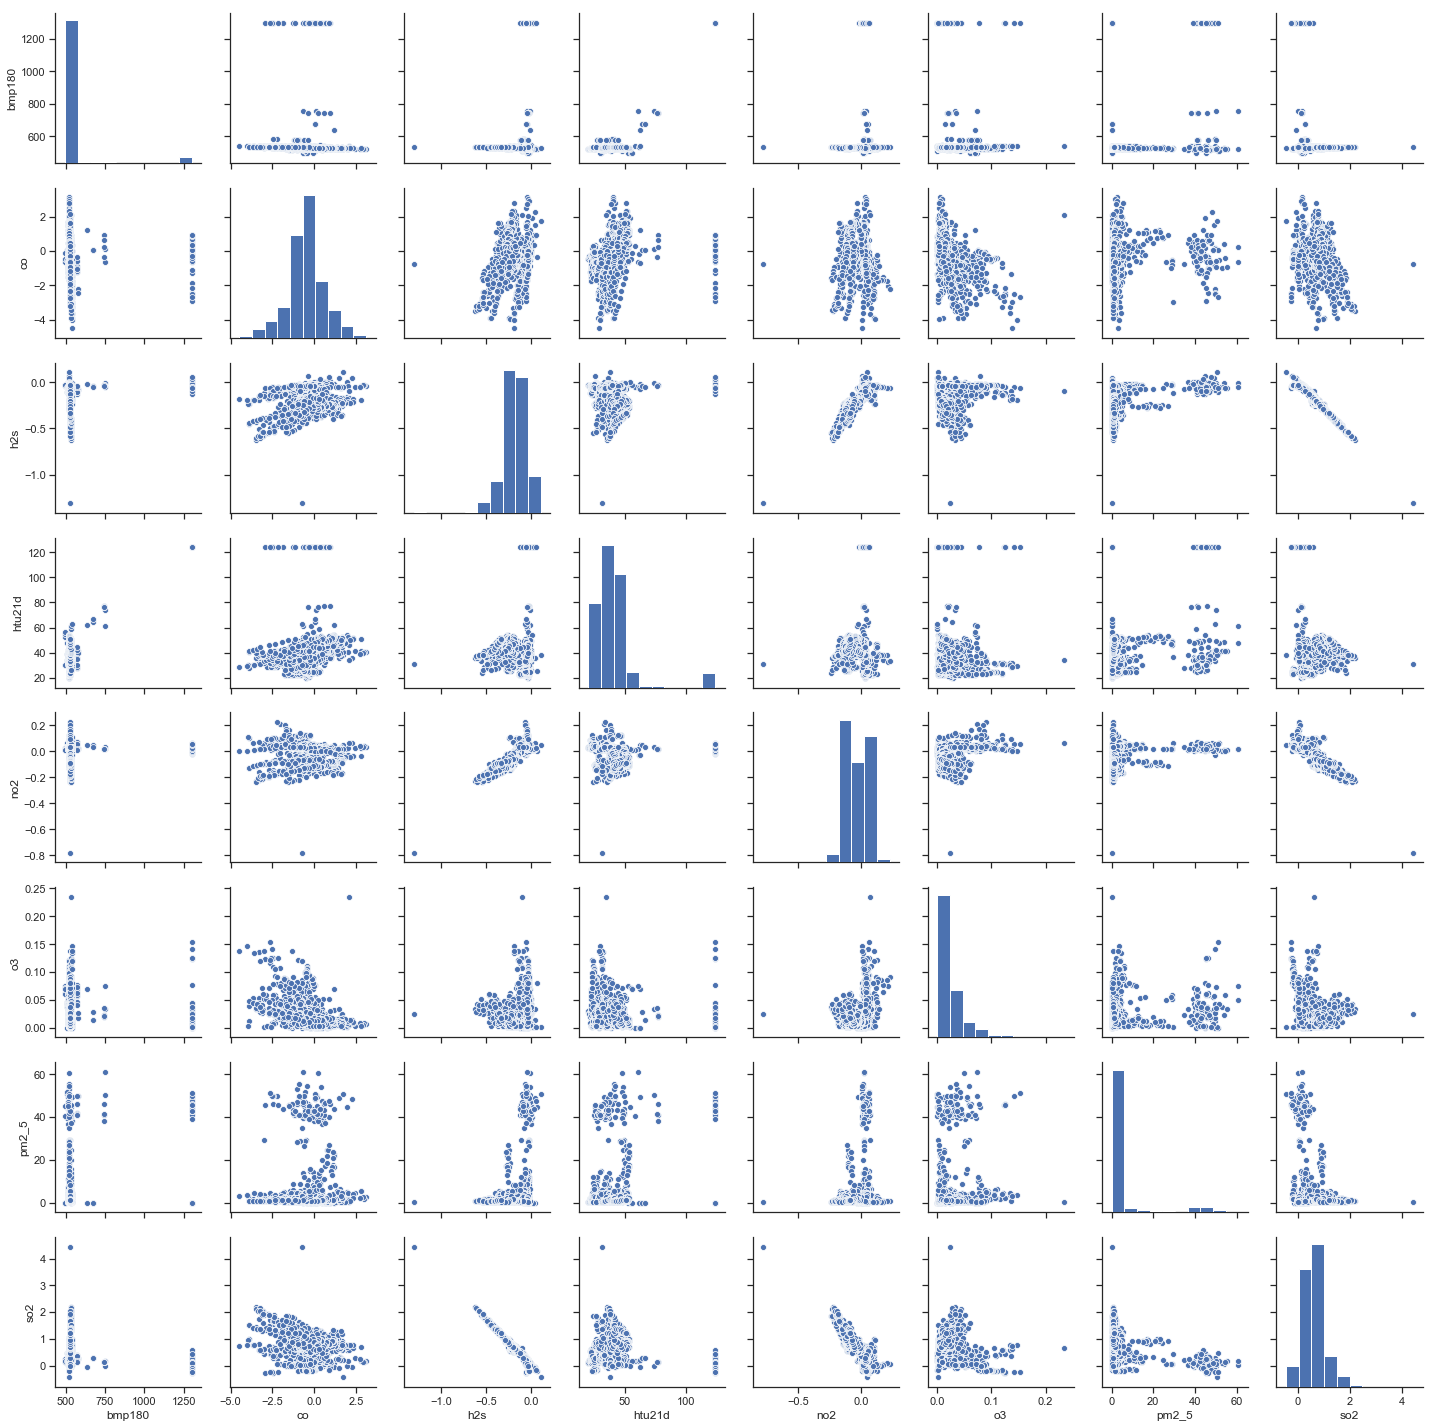

In [67]:
sns.pairplot(metric_table[['bmp180','co','h2s','htu21d','no2', 'o3', 'pm2_5', 'so2']])